In [1]:
#!pip3 install tensorboard
!pip3 install tensorboardx
    
import datetime, os
import time
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid
import pickle
import cv2
from io import BytesIO
from PIL import Image
import zipfile
import gc
import math, os
from random import shuffle
import matplotlib.pyplot as plt
from tensorboardX import SummaryWriter

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
train_transforms = torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.5,), (0.5,))
                             ])

mnist_train = torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=train_transforms)

mnist_test = torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=train_transforms)

class Excluded_mnist(Dataset):
    def __init__(self, dataset, classes_for_excluding = [3]):
      self.dataset = dataset
      self.samples_indices = []
      for i in range(len(dataset.targets)):
        if int(dataset.targets[i]) not in classes_for_excluding:
          self.samples_indices.append(i)
      print(f"Original dataset len: {len(dataset)}, Excluded (classes {classes_for_excluding}) dataset len: {len(self.samples_indices)}")
    
    def __len__(self):
      return len(self.samples_indices)

    def __getitem__(self, index):
      i = self.samples_indices[index]
      return self.dataset[i]
    
excluded_set = Excluded_mnist(mnist_train, classes_for_excluding=[3,4])
excluded_set[0][0].size()

Original dataset len: 60000, Excluded (classes [3, 4]) dataset len: 48027


torch.Size([1, 28, 28])

In [3]:
class MLP(nn.Module):
    def __init__(self, hidden_neuron_count=100):
        super(MLP, self).__init__()
        inp_size = 28*28
        self.layers = nn.Sequential(
            nn.Linear(inp_size, hidden_neuron_count),
            nn.ReLU(),
            nn.Linear(hidden_neuron_count, hidden_neuron_count),
            nn.ReLU(),
            nn.Linear(hidden_neuron_count, 10),
        )
        print(f"Model {inp_size} - {hidden_neuron_count} - {hidden_neuron_count} - {10} created")

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.layers(x)
        return x



Original dataset len: 60000, Excluded (classes [3]) dataset len: 53869


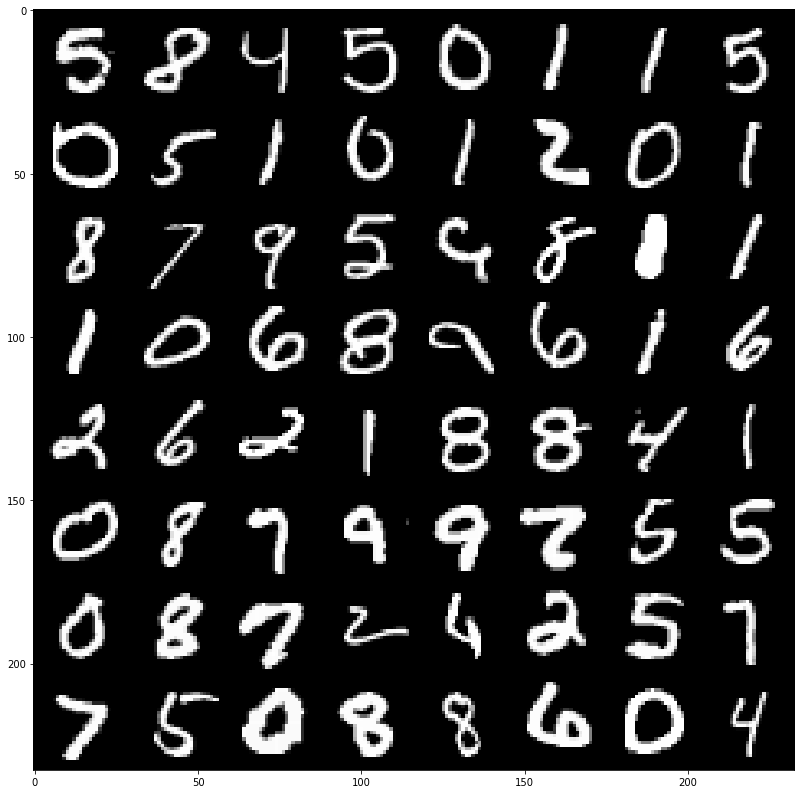

In [4]:

def prin_batch():
    BS = 64
    TRAIN=1

    # mnist_train excluded_set
    test_loader = DataLoader(Excluded_mnist(mnist_train, classes_for_excluding=[3]), batch_size=BS, shuffle=True)
    
    epochs = 0
    epoch = 0
    images, labels = iter(test_loader).next()
    #print(images.shape, labels.shape)
    
    img = images.data 
    #print(img.min(), img.max())
    img = img - img.min()
    img = img / img.max()
    img = make_grid(img, nrow=8, padding=1).numpy()
    #print(img.shape, img.dtype, img.max(), img.min())
    img = np.rollaxis(img, 0, 3)

    plt.figure(figsize=(14, 14)), plt.imshow(img), plt.show()
    if False:
        plt.figure(figsize=(14, 5)), plt.imshow(img[:,:,0]), plt.show()
        plt.figure(figsize=(14, 5)), plt.imshow(img[:,:,1]), plt.show()
        plt.figure(figsize=(14, 5)), plt.imshow(img[:,:,2]), plt.show()
prin_batch()

In [6]:
#TRAIN TEACHER
BS = 512
LR = 0.1 
WD = 0
MOMENTUM = 0.9

SAVE_MODEL = True
CLASS_COUNT = 10

TEACHER_PATH = "/content/drive/My Drive/models/teacher1.pt" 
LOAD = False
CUDA = torch.cuda.is_available()

loss_fn = nn.CrossEntropyLoss()

def smooth_loss(pred, gold, eps = 0.1):
    ''' Calculate cross entropy loss, apply label smoothing if needed. '''

    gold = gold.contiguous().view(-1)

    if eps:
        n_class = pred.size(1)

        one_hot = torch.zeros_like(pred).scatter(1, gold.view(-1, 1), 1)
        one_hot = one_hot * (1 - eps) + (1 - one_hot) * eps / (n_class - 1)
        log_prb = F.log_softmax(pred, dim=1)

        loss = -(one_hot * log_prb).sum() / pred.size(0)
    else:
        loss = F.cross_entropy(pred, gold)
    return loss

#writer = SummaryWriter(logdir='./runs/{}'.format(datetime.datetime.now().strftime("%B_%d_%Y_%H_%M")))
mean_train_losses, mean_test_losses, train_acc_list, test_acc_list, balanced_test_acc = None, None, None, None, None
def train_teacher():
    global mean_train_losses, mean_test_losses, train_acc_list, test_acc_list, balanced_test_acc
    gc.collect()
    mean_train_losses = []
    mean_test_losses = []
    test_acc_list = []
    train_acc_list = []
    balanced_test_acc = []

    valid_loader = DataLoader(mnist_test, batch_size=BS, shuffle=True, num_workers=1)
    train_loader = DataLoader(mnist_train, batch_size=BS, shuffle=True, num_workers=1)
    epochs = 50
    best_acc = 0
    # torch.save(model, PATH)
    # print(f"Model was dumped to {PATH}")

    
    # model.eval()
    print("train started")
    
    model = MLP(hidden_neuron_count=1200)
    epoch_start = 0
    
    if CUDA:
        device = 'cuda'
        gc.collect()
        torch.cuda.empty_cache()
        model.to(device)
    
    optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=MOMENTUM, weight_decay=0, nesterov=True)
    #optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.999), eps=1e-08, weight_decay=WD, amsgrad=False)
    #scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True, patience=4, factor=0.1, threshold=0.01 )
    #scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5,10, 15], gamma=0.1)
    #scheduler =  MyWarmupCosineAnnealingLR(optimizer,linear_lr_m, T_max, eta_min=eta_min, sin_max=SIN_MAX, last_epoch=-1)



    for epoch in range(epoch_start, epochs):
        print(f"epoch : {epoch}")
        epoch_start_time = time.time()
        model.train()

        correct = np.zeros(CLASS_COUNT)
        total = np.zeros(CLASS_COUNT)
        train_losses = []
        test_losses = []
        iter_count = len(train_loader)
        for i, (images, label_batch) in enumerate(train_loader):

            if CUDA:
                images = images.to(device)
                labels = label_batch.to(device)
            else:
                labels = label_batch
            
            optimizer.zero_grad()

            outputs = model(images)

            _, predicted = torch.max(outputs.data, 1)

            np.add.at(correct, label_batch[(predicted == labels)], 1)
            np.add.at(total,label_batch,1)

            #loss = loss_fn(outputs, labels)
            loss = smooth_loss(outputs, labels)
            
            #writer.add_scalar("TRAIN LOSS(BATCH)/loss",loss.item(), epoch*iter_count + i)

            '''
            reg_loss = (model.decoder.weight ** 2).sum()
            for param in model.conv_weights:
                reg_loss += (param ** 2).sum() 
            reg_loss = WD*reg_loss
            loss = loss + reg_loss
            '''
            
            
            loss.backward()
            optimizer.step()
            

            train_losses.append(loss.item())
            
            
            print(f"\r\ttraining {i}/{iter_count} | curr_acc {np.round(correct / total,3)} loss: {train_losses[-1]}", end="")

        
        t_accuracy = correct.sum() / total.sum()
        train_acc_list.append(t_accuracy)
        model.eval()
        correct = np.zeros(CLASS_COUNT)
        total = np.zeros(CLASS_COUNT)
        print()
        iter_count = len(valid_loader)
        with torch.no_grad():
            for i, (images, label_batch) in enumerate(valid_loader):
                

                if CUDA:
                    images = images.to(device)
                    labels = label_batch.to(device)
                else:
                    labels = label_batch

                outputs = model(images)
                loss = loss_fn(outputs, labels)
                
                
                
                test_losses.append(loss.item())
                #writer.add_scalar("VALID LOSS(BATCH)",loss.item(), epoch*iter_count + i)

                _, predicted = torch.max(outputs.data, 1)
                np.add.at(correct, label_batch[(predicted == labels)], 1)
                np.add.at(total,label_batch,1)
                print(f"\r\tvalidating {i}/{iter_count} | curr_acc {np.round(correct / total, 3)} test_loss: {test_losses[-1]}", end="")

        mean_train_losses.append(np.mean(train_losses))
        mean_test_losses.append(np.mean(test_losses))
        
        #scheduler.step(mean_test_losses[-1])
        #scheduler.step()
        
        
        
        accuracy = correct.sum() / total.sum()
        balanced_test_acc.append(np.mean(correct / total))
        test_acc_list.append(correct.sum() / total.sum())
        
        print('\n\ttrain loss : {}, test loss : {}, train acc : {}, test acc : {}, epoch_time: {}s, best_accuracy: {}, error count: {}' \
              .format( mean_train_losses[-1], mean_test_losses[-1], np.round(t_accuracy,2), np.round(accuracy,4), int(time.time()-epoch_start_time), best_acc, total.sum() - correct.sum()))
              
              
        if SAVE_MODEL and accuracy > best_acc:
            torch.save(model, TEACHER_PATH) # {balanced_test_acc[-1]}
            best_acc =accuracy
            print(f"Model was dumped to {TEACHER_PATH} acc: {accuracy}")

            teacher_model = torch.load(TEACHER_PATH)

            if CUDA:
                device = 'cuda'
                gc.collect()
                torch.cuda.empty_cache()
                model.to(device)
                teacher_model.to(device)

            correct = np.zeros(CLASS_COUNT)
            total = np.zeros(CLASS_COUNT)

            for i, (images, label_batch) in enumerate(valid_loader):
              if CUDA:
                images = images.to(device)
                labels = label_batch.to(device)
              else:
                labels = label_batch
              outputs = teacher_model(images)

              _, predicted = torch.max(outputs.data, 1)

              np.add.at(correct, label_batch[(predicted == labels)], 1)
              np.add.at(total,label_batch,1)
            print(f"teacher accuracy: {correct.sum()/total.sum()}, errors: {total - correct}, full errors: {total.sum() - correct.sum()}")

            

train_teacher()



train started
Model 784 - 1200 - 1200 - 10 created
epoch : 0
	training 117/118 | curr_acc [0.879 0.85  0.719 0.71  0.687 0.638 0.767 0.746 0.673 0.664] loss: 0.7437634468078613
	validating 19/20 | curr_acc [0.985 0.988 0.953 0.955 0.976 0.867 0.928 0.901 0.917 0.573] test_loss: 0.37030431628227234
	train loss : 1.261240965734094, test loss : 0.3870604932308197, train acc : 0.74, test acc : 0.9051, epoch_time: 15s, best_accuracy: 0, error count: 949.0
Model was dumped to /content/drive/My Drive/models/teacher1.pt acc: 0.9051
teacher accuracy: 0.9051, errors: [ 15.  14.  49.  45.  24. 119.  69. 102.  81. 431.], full errors: 949.0
epoch : 1
	training 117/118 | curr_acc [0.978 0.978 0.945 0.93  0.949 0.935 0.972 0.962 0.933 0.92 ] loss: 0.6431303024291992
	validating 19/20 | curr_acc [0.993 0.983 0.966 0.935 0.981 0.948 0.963 0.953 0.956 0.891] test_loss: 0.22362934052944183
	train loss : 0.6914775765548318, test loss : 0.2488424815237522, train acc : 0.95, test acc : 0.9572, epoch_time: 1

KeyboardInterrupt: ignored

In [ ]:
!./ngrok authtoken 1kHcI0NiZjcxHDqui6dzTXpIL4U_4JWzssQkKjZvGjJTsrPA1
!./ngrok start --config /root/.ngrok2/ngrok.yml --config ./tensorboard.yml tensorboard

Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml
Your account 'vlad9n116@gmail.com' is limited to 1 simultaneous ngrok client session.
Active ngrok client sessions in region 'us':
  - ts_1lsV2ik4fEc2UWc9bdqIv24r1iI (104.199.171.194)

ERR_NGROK_108



In [ ]:
%%writefile ./tensorboard.yml
tunnels:
  tensorboard:
    proto: http
    addr: 1337
    inspect: false
    bind_tls: true

Writing ./tensorboard.yml


student train started, hidden_neuron_count - 20
Model 784 - 20 - 20 - 10 created
STUDENT_MODEL:
MLP(
  (layers): Sequential(
    (0): Linear(in_features=784, out_features=20, bias=True)
    (1): ReLU()
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): ReLU()
    (4): Linear(in_features=20, out_features=10, bias=True)
  )
)
teacher accuracy: 0.9834, errors: [ 6.  6. 20. 11. 16. 15. 21. 26. 17. 28.], full errors: 166.0
epoch : 0
	training 468/469 | curr_acc [0.924 0.921 0.741 0.812 0.817 0.717 0.914 0.875 0.784 0.761] loss: 0.3415265679359436, dist_loss: 0.1025841236114502 celoss: 0.23894242942333221
	validating 78/79 | curr_acc [0.982 0.97  0.886 0.899 0.907 0.877 0.949 0.912 0.852 0.93 ] test_loss: 0.1409466564655304
	train loss : 0.6990548229293783, test loss : 0.29124699627296835, train acc : 0.83, test acc : 0.9173, epoch_time: 18s, best_accuracy: 0, error count: 827.0 errors: [ 18.  34. 118. 102.  91. 110.  49.  90. 144.  71.] mean_dist_loss: 0.120189469458579 me

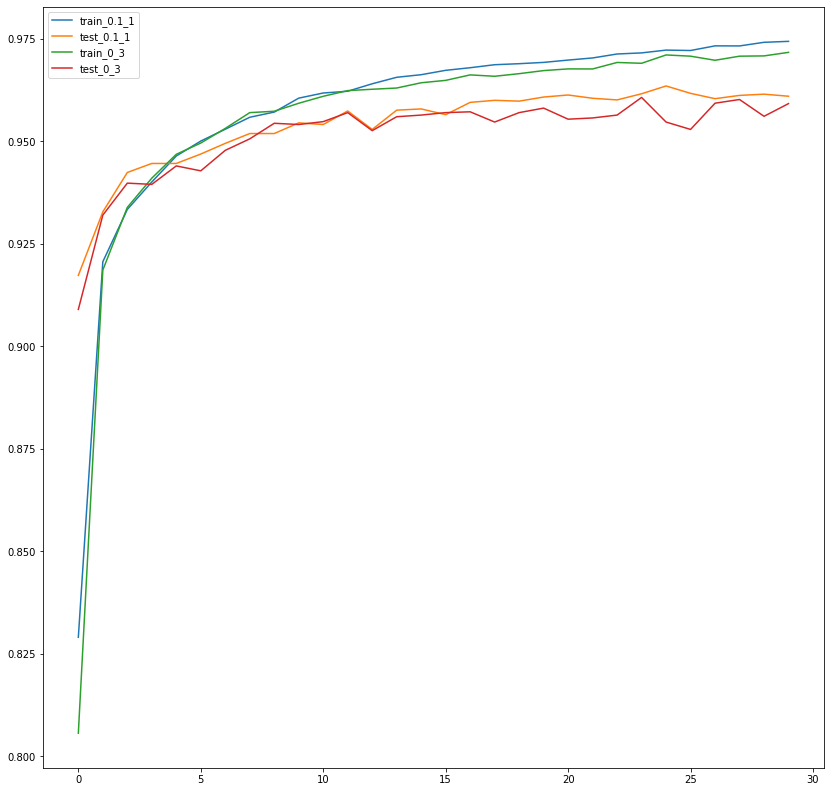

In [15]:
#TRAIN STUDEN
BS = 128
LR = 0.01
WD = 0
MOMENTUM = 0.9


TEACHER_PATH = "/content/drive/My Drive/models/teacher1.pt" 
STUDENT_PATH = "/content/drive/My Drive/models/student.pt" 
SAVE_MODEL = False
CLASS_COUNT = 10

CUDA = torch.cuda.is_available()



ce_loss_fn = nn.CrossEntropyLoss() #nn.NLLLoss()
def distilation_loss(pred, teacher_outs, T = 0.1, _l=0.1):
    teacher_preds = F.softmax(teacher_outs, dim=1)
    log_prb = F.log_softmax(pred / T, dim=1)

    loss = (teacher_preds * log_prb).sum() / pred.size(0)

    #print(" ",loss)
    return - _l * T**2 * loss



#writer = SummaryWriter(logdir='./runs/{}'.format(datetime.datetime.now().strftime("%B_%d_%Y_%H_%M")))
mean_train_losses, mean_test_losses, train_acc_list, test_acc_list, balanced_test_acc = None, None, None, None, None
def train_student():
    global mean_train_losses, mean_test_losses, train_acc_list, test_acc_list, balanced_test_acc

    writer = SummaryWriter(logdir='/content/drive/My Drive/datasets/runs/student_{}_{}_{}'.format(LA, T, datetime.datetime.now().strftime("%H:%M:%S")))
    gc.collect()
    mean_train_losses = []
    mean_test_losses = []
    mean_train_dist_losses = []
    mean_train_ce_losses = []
    test_acc_list = []
    train_acc_list = []
    balanced_test_acc = []
    

    valid_loader = DataLoader(mnist_test, batch_size=BS, shuffle=True, num_workers=1)
    train_loader = DataLoader(mnist_train, batch_size=BS, shuffle=True, num_workers=1)
    epochs = 30
    best_acc = 0
    # torch.save(model, PATH)
    # print(f"Model was dumped to {PATH}")

    
    # model.eval()
    hidden = 20
    print(f"student train started, hidden_neuron_count - {hidden}")
     #nn.CrossEntropyLoss()

    model = MLP(hidden_neuron_count=hidden) #student
    print("STUDENT_MODEL:")
    print(model)
    

    teacher_model = torch.load(TEACHER_PATH)

    if CUDA:
        device = 'cuda'
        gc.collect()
        torch.cuda.empty_cache()
        model = model.to(device)
        teacher_model = teacher_model.to(device)

    correct = np.zeros(CLASS_COUNT)
    total = np.zeros(CLASS_COUNT)

    for i, (images, label_batch) in enumerate(valid_loader):
      if CUDA:
        images = images.to(device)
        labels = label_batch.to(device)
      else:
        labels = label_batch
      outputs = teacher_model(images)

      _, predicted = torch.max(outputs.data, 1)

      np.add.at(correct, label_batch[(predicted == labels)], 1)
      np.add.at(total,label_batch,1)
    print(f"teacher accuracy: {correct.sum()/total.sum()}, errors: {total - correct}, full errors: {total.sum() - correct.sum()}")


    epoch_start = 0

    optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=MOMENTUM, weight_decay=0, nesterov=True)
    #optimizer = torch.optim.Adam(model.parameters(), lr=LR, betas=(0.9, 0.999), eps=1e-08, weight_decay=WD, amsgrad=False)
    #scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True, patience=4, factor=0.1, threshold=0.01 )
    #scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5,10, 15], gamma=0.1)
    #scheduler =  MyWarmupCosineAnnealingLR(optimizer,linear_lr_m, T_max, eta_min=eta_min, sin_max=SIN_MAX, last_epoch=-1)



    for epoch in range(epoch_start, epochs):
        print(f"epoch : {epoch}")
        epoch_start_time = time.time()
        model.train()

        correct = np.zeros(CLASS_COUNT)
        total = np.zeros(CLASS_COUNT)
        train_losses = []
        test_losses = []
        dist_losses = []
        ce_losses = []
        iter_count = len(train_loader)
        for i, (images, label_batch) in enumerate(train_loader):

            if CUDA:
                images = images.to(device)
                labels = label_batch.to(device)
            else:
                labels = label_batch
            
            optimizer.zero_grad()

            outputs = model(images)

            teacher_outputs = teacher_model(images)

            _, predicted = torch.max(outputs.data, 1)

            np.add.at(correct, label_batch[(predicted == labels)], 1)
            np.add.at(total,label_batch,1)

            ce_loss = ce_loss_fn(outputs, labels)
            dist_loss = distilation_loss(outputs, teacher_outputs, T = T, _l=LA)
            
            loss = ce_loss + dist_loss

            dist_losses.append(dist_loss.item())
            ce_losses.append(ce_loss.item())
            #loss = smooth_loss(outputs, labels, eps=LS_EPS)
            
            #writer.add_scalar("TRAIN LOSS(BATCH)/loss",loss.item(), epoch*iter_count + i)

            '''
            reg_loss = (model.decoder.weight ** 2).sum()
            for param in model.conv_weights:
                reg_loss += (param ** 2).sum() 
            reg_loss = WD*reg_loss
            loss = loss + reg_loss
            '''
            
            
            loss.backward()
            optimizer.step()
            

            train_losses.append(loss.item())
            
            
            print(f"\r\ttraining {i}/{iter_count} | curr_acc {np.round(correct / total,3)} loss: {train_losses[-1]}, dist_loss: {dist_losses[-1]} celoss: {ce_losses[-1]}", end="")

        
        t_accuracy = correct.sum() / total.sum()
        train_acc_list.append(t_accuracy)
        model.eval()
        correct = np.zeros(CLASS_COUNT)
        total = np.zeros(CLASS_COUNT)
        print()
        iter_count = len(valid_loader)
        with torch.no_grad():
            for i, (images, label_batch) in enumerate(valid_loader):
                

                if CUDA:
                    images = images.to(device)
                    labels = label_batch.to(device)
                else:
                    labels = label_batch

                outputs = model(images)
                loss = ce_loss_fn(outputs, labels)
                
                
                
                test_losses.append(loss.item())
                #writer.add_scalar("VALID LOSS(BATCH)",loss.item(), epoch*iter_count + i)

                _, predicted = torch.max(outputs.data, 1)
                np.add.at(correct, label_batch[(predicted == labels)], 1)
                np.add.at(total,label_batch,1)
                print(f"\r\tvalidating {i}/{iter_count} | curr_acc {np.round(correct / total, 3)} test_loss: {test_losses[-1]}", end="")

        mean_train_losses.append(np.mean(train_losses))
        mean_test_losses.append(np.mean(test_losses))
        mean_train_dist_losses.append(np.mean(dist_losses))
        mean_train_ce_losses.append(np.mean(ce_losses))
        #scheduler.step(mean_test_losses[-1])
        #scheduler.step()
        
        
        
        accuracy = correct.sum() / total.sum()
        balanced_test_acc.append(np.mean(correct / total))
        test_acc_list.append(correct.sum() / total.sum())

        writer.add_scalars('Total/Acc', {'valid':test_acc_list[-1] , 'train': train_acc_list[-1]}, epoch)
        writer.add_scalars('Total/Loss', {'valid':mean_test_losses[-1] , 'train': mean_train_losses[-1], 'train_dist':mean_train_dist_losses[-1], 'train_ce':mean_train_ce_losses[-1]}, epoch)

        
        print('\n\ttrain loss : {}, test loss : {}, train acc : {}, test acc : {}, epoch_time: {}s, best_accuracy: {}, error count: {} errors: {} mean_dist_loss: {} mean_ce_loss: {}' \
              .format( mean_train_losses[-1], mean_test_losses[-1], np.round(t_accuracy,2), np.round(accuracy,4), int(time.time()-epoch_start_time), best_acc, total.sum() - correct.sum(), total - correct, mean_train_dist_losses[-1], mean_train_ce_losses[-1] ))
              
        if accuracy > best_acc:
            if SAVE_MODEL:
              torch.save(model, STUDENT_PATH) # {balanced_test_acc[-1]}
            best_acc =accuracy
            print(f"NEW BES ACCURACY :{best_acc}")
    
    plt.plot(range(epochs), train_acc_list, label='train_{}_{}'.format(LA,T))
    plt.plot(range(epochs), test_acc_list, label='test_{}_{}'.format(LA,T))
    
plt.figure(figsize=(14, 14))
LA, T = 0.1, 1#0.5, 3
train_student()
LA, T = 0, 3 #0.5, 3
train_student()
plt.legend()
plt.show()


In [16]:
#TRAIN STUDEN WITHOUT CLASS 3
BS = 128
LR = 0.01
WD = 0
MOMENTUM = 0.9


TEACHER_PATH = "/content/drive/My Drive/models/teacher1.pt" 
STUDENT_PATH = "/content/drive/My Drive/models/student_without_class_3.pt" 
SAVE_MODEL = True
CLASS_COUNT = 10

CUDA = torch.cuda.is_available()

LA, T = 0.1, 1

ce_loss_fn = nn.CrossEntropyLoss() #nn.NLLLoss()
def distilation_loss(pred, teacher_outs, T = 0.1, _l=0.1):
    teacher_preds = F.softmax(teacher_outs, dim=1)
    log_prb = F.log_softmax(pred / T, dim=1)

    loss = (teacher_preds * log_prb).sum() / pred.size(0)

    #print(" ",loss)
    return - _l * T**2 * loss



#writer = SummaryWriter(logdir='./runs/{}'.format(datetime.datetime.now().strftime("%B_%d_%Y_%H_%M")))
mean_train_losses, mean_test_losses, train_acc_list, test_acc_list, balanced_test_acc = None, None, None, None, None
def train_student():
    global mean_train_losses, mean_test_losses, train_acc_list, test_acc_list, balanced_test_acc

    writer = SummaryWriter(logdir='/content/drive/My Drive/datasets/runs/student_{}_{}'.format(LA, T))
    gc.collect()
    mean_train_losses = []
    mean_test_losses = []
    mean_train_dist_losses = []
    mean_train_ce_losses = []
    test_acc_list = []
    train_acc_list = []
    balanced_test_acc = []
    

    valid_loader = DataLoader(mnist_test, batch_size=BS, shuffle=True, num_workers=1)
    train_loader = DataLoader(Excluded_mnist(mnist_train, classes_for_excluding=[3]), batch_size=BS, shuffle=True, num_workers=1)
    epochs = 50
    best_acc = 0
    # torch.save(model, PATH)
    # print(f"Model was dumped to {PATH}")

    
    # model.eval()
    hidden = 20
    print(f"student train started, hidden_neuron_count - {hidden}")
     #nn.CrossEntropyLoss()

    model = MLP(hidden_neuron_count=hidden) #student
    print("STUDENT_MODEL:")
    print(model)
    

    teacher_model = torch.load(TEACHER_PATH)

    if CUDA:
        device = 'cuda'
        gc.collect()
        torch.cuda.empty_cache()
        model = model.to(device)
        teacher_model = teacher_model.to(device)

    correct = np.zeros(CLASS_COUNT)
    total = np.zeros(CLASS_COUNT)

    for i, (images, label_batch) in enumerate(valid_loader):
      if CUDA:
        images = images.to(device)
        labels = label_batch.to(device)
      else:
        labels = label_batch
      outputs = teacher_model(images)

      _, predicted = torch.max(outputs.data, 1)

      np.add.at(correct, label_batch[(predicted == labels)], 1)
      np.add.at(total,label_batch,1)
    print(f"teacher accuracy: {correct.sum()/total.sum()}, errors: {total - correct}, full errors: {total.sum() - correct.sum()}")


    epoch_start = 0

    optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=MOMENTUM, weight_decay=0, nesterov=True)
    #optimizer = torch.optim.Adam(model.parameters(), lr=LR, betas=(0.9, 0.999), eps=1e-08, weight_decay=WD, amsgrad=False)
    #scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True, patience=4, factor=0.1, threshold=0.01 )
    #scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5,10, 15], gamma=0.1)
    #scheduler =  MyWarmupCosineAnnealingLR(optimizer,linear_lr_m, T_max, eta_min=eta_min, sin_max=SIN_MAX, last_epoch=-1)



    for epoch in range(epoch_start, epochs):
        print(f"epoch : {epoch}")
        epoch_start_time = time.time()
        model.train()

        correct = np.zeros(CLASS_COUNT)
        total = np.zeros(CLASS_COUNT)
        train_losses = []
        test_losses = []
        dist_losses = []
        ce_losses = []
        iter_count = len(train_loader)
        for i, (images, label_batch) in enumerate(train_loader):

            if CUDA:
                images = images.to(device)
                labels = label_batch.to(device)
            else:
                labels = label_batch
            
            optimizer.zero_grad()

            outputs = model(images)

            teacher_outputs = teacher_model(images)

            _, predicted = torch.max(outputs.data, 1)

            np.add.at(correct, label_batch[(predicted == labels)], 1)
            np.add.at(total,label_batch,1)

            ce_loss = ce_loss_fn(outputs, labels)
            dist_loss = distilation_loss(outputs, teacher_outputs, T=T, _l=LA)
            
            loss = ce_loss  + dist_loss

            dist_losses.append(dist_loss.item())
            ce_losses.append(ce_loss.item())
            #loss = smooth_loss(outputs, labels, eps=LS_EPS)
            
            #writer.add_scalar("TRAIN LOSS(BATCH)/loss",loss.item(), epoch*iter_count + i)

            '''
            reg_loss = (model.decoder.weight ** 2).sum()
            for param in model.conv_weights:
                reg_loss += (param ** 2).sum() 
            reg_loss = WD*reg_loss
            loss = loss + reg_loss
            '''
            
            
            loss.backward()
            optimizer.step()
            

            train_losses.append(loss.item())
            
            
            print(f"\r\ttraining {i}/{iter_count} | curr_acc {np.round(correct / total,3)} loss: {train_losses[-1]}, dist_loss: {dist_losses[-1]} celoss: {ce_losses[-1]}", end="")

        
        t_accuracy = correct.sum() / total.sum()
        train_acc_list.append(t_accuracy)
        model.eval()
        correct = np.zeros(CLASS_COUNT)
        total = np.zeros(CLASS_COUNT)
        print()
        iter_count = len(valid_loader)
        with torch.no_grad():
            for i, (images, label_batch) in enumerate(valid_loader):
                

                if CUDA:
                    images = images.to(device)
                    labels = label_batch.to(device)
                else:
                    labels = label_batch

                outputs = model(images)
                loss = ce_loss_fn(outputs, labels)
                
                
                
                test_losses.append(loss.item())
                #writer.add_scalar("VALID LOSS(BATCH)",loss.item(), epoch*iter_count + i)

                _, predicted = torch.max(outputs.data, 1)
                np.add.at(correct, label_batch[(predicted == labels)], 1)
                np.add.at(total,label_batch,1)
                print(f"\r\tvalidating {i}/{iter_count} | curr_acc {np.round(correct / total, 3)} test_loss: {test_losses[-1]}", end="")

        mean_train_losses.append(np.mean(train_losses))
        mean_test_losses.append(np.mean(test_losses))
        mean_train_dist_losses.append(np.mean(dist_losses))
        mean_train_ce_losses.append(np.mean(ce_losses))
        #scheduler.step(mean_test_losses[-1])
        #scheduler.step()
        
        
        
        accuracy = correct.sum() / total.sum()
        balanced_test_acc.append(np.mean(correct / total))
        test_acc_list.append(correct.sum() / total.sum())

        writer.add_scalars('Total/Acc', {'valid':test_acc_list[-1] , 'train': train_acc_list[-1]}, epoch)
        writer.add_scalars('Total/Loss', {'valid':mean_test_losses[-1] , 'train': mean_train_losses[-1], 'train_dist':mean_train_dist_losses[-1], 'train_ce':mean_train_ce_losses[-1]}, epoch)

        
        print('\n\ttrain loss : {}, test loss : {}, train acc : {}, test acc : {}, epoch_time: {}s, best_accuracy: {}, error count: {} errors: {} mean_dist_loss: {} mean_ce_loss: {}' \
              .format( mean_train_losses[-1], mean_test_losses[-1], np.round(t_accuracy,2), np.round(accuracy,4), int(time.time()-epoch_start_time), best_acc, total.sum() - correct.sum(), total - correct, mean_train_dist_losses[-1], mean_train_ce_losses[-1] ))
              
        if accuracy > best_acc:
            if SAVE_MODEL:
              torch.save(model, STUDENT_PATH) # {balanced_test_acc[-1]}
            best_acc =accuracy
            print(f"NEW BES ACCURACY :{best_acc}")
    
    plt.plot(range(epochs), train_acc_list, label='train_{}_{}'.format(LA,T))
    plt.plot(range(epochs), test_acc_list, label='test_{}_{}'.format(LA,T))
    
plt.figure(figsize=(14, 14))
train_student()
plt.legend()
plt.show()


Original dataset len: 60000, Excluded (classes [3]) dataset len: 53869
student train started, hidden_neuron_count - 20
Model 784 - 20 - 20 - 10 created
STUDENT_MODEL:
MLP(
  (layers): Sequential(
    (0): Linear(in_features=784, out_features=20, bias=True)
    (1): ReLU()
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): ReLU()
    (4): Linear(in_features=20, out_features=10, bias=True)
  )
)
teacher accuracy: 0.9834, errors: [ 6.  6. 20. 11. 16. 15. 21. 26. 17. 28.], full errors: 166.0
epoch : 0
	training 3/421 | curr_acc [0.094 0.    0.      nan 0.    0.    0.    0.    0.981 0.   ] loss: 2.4839394092559814, dist_loss: 0.2262551337480545 celoss: 2.2576842308044434

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:158: RuntimeWarning: invalid value encountered in true_divide


	training 420/421 | curr_acc [0.936 0.941 0.837   nan 0.817 0.782 0.886 0.853 0.784 0.79 ] loss: 0.27828875184059143, dist_loss: 0.09690989553928375 celoss: 0.18137885630130768
	validating 78/79 | curr_acc [0.968 0.984 0.91  0.    0.924 0.902 0.941 0.946 0.789 0.897] test_loss: 1.2014662027359009
	train loss : 0.6271794812129965, test loss : 0.8018354713162289, train acc : 0.85, test acc : 0.8264, epoch_time: 17s, best_accuracy: 0, error count: 1736.0 errors: [  31.   18.   93. 1010.   75.   87.   57.   55.  206.  104.] mean_dist_loss: 0.11918377998393392 mean_ce_loss: 0.5079956997247886
NEW BES ACCURACY :0.8264
epoch : 1
	training 420/421 | curr_acc [0.967 0.969 0.914   nan 0.936 0.904 0.961 0.942 0.9   0.91 ] loss: 0.25762924551963806, dist_loss: 0.0954664871096611 celoss: 0.16216275095939636
	validating 78/79 | curr_acc [0.982 0.979 0.92  0.    0.956 0.895 0.963 0.911 0.895 0.933] test_loss: 0.7062941193580627
	train loss : 0.3303447471590903, test loss : 0.7203710984580124, train a

KeyboardInterrupt: ignored

<Figure size 1008x1008 with 0 Axes>

MLP(
  (layers): Sequential(
    (0): Linear(in_features=784, out_features=20, bias=True)
    (1): ReLU()
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): ReLU()
    (4): Linear(in_features=20, out_features=10, bias=True)
  )
)
Linear(in_features=20, out_features=10, bias=True)
Parameter containing:
tensor([ 0.2366,  0.1412, -0.1885, -0.4347,  0.2717, -0.1657, -0.0752, -0.0125,
         0.1489,  0.1744], device='cuda:0', requires_grad=True)
bias: 3.0 accuracy: 0.8934, errors: [ 18.  20.  40. 751.  40.  42.  25.  42.  54.  34.], full errors: 1066.0
bias: 3.061224489795918 accuracy: 0.8945, errors: [ 19.  22.  43. 729.  40.  43.  25.  43.  56.  35.], full errors: 1055.0
bias: 3.122448979591837 accuracy: 0.8954, errors: [ 20.  22.  45. 713.  40.  45.  25.  44.  57.  35.], full errors: 1046.0
bias: 3.183673469387755 accuracy: 0.8964, errors: [ 20.  22.  46. 698.  40.  45.  27.  45.  58.  35.], full errors: 1036.0
bias: 3.2448979591836733 accuracy: 0.8982, errors: [ 21. 

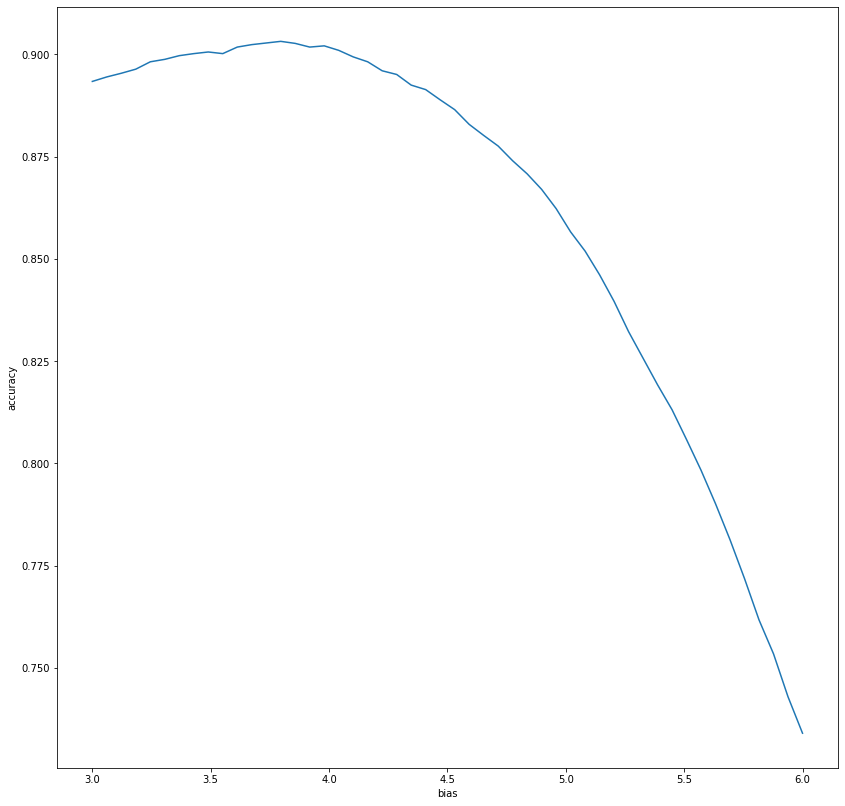

In [ ]:

STUDENT_PATH = "/content/drive/My Drive/models/student_without_class_3.pt" 


def bias_correction():
    gc.collect()
    
    valid_loader = DataLoader(mnist_test, batch_size=256, shuffle=True, num_workers=1)
    
    student_model = torch.load(STUDENT_PATH)

    if CUDA:
        device = 'cuda'
        gc.collect()
        torch.cuda.empty_cache()
        student_model = student_model.to(device)

    print(student_model)
    print(student_model.layers[4])

    #student_model.layers[4].bias[3]=10

    print(student_model.layers[4].bias)
    #return
    
    accuracy = []
    biases = np.linspace(3,6,50)#range(60, 100, 1)
    for bias in biases:

      student_model.layers[4].bias[3]=bias
      
      correct = np.zeros(CLASS_COUNT)
      total = np.zeros(CLASS_COUNT)
      for i, (images, label_batch) in enumerate(valid_loader):
        if CUDA:
          images = images.to(device)
          labels = label_batch.to(device)
        else:
          labels = label_batch
        outputs = student_model(images)

        _, predicted = torch.max(outputs.data, 1)

        np.add.at(correct, label_batch[(predicted == labels)], 1)
        np.add.at(total,label_batch,1)
      accuracy.append(correct.sum()/total.sum())
      print(f"bias: {bias} accuracy: {correct.sum()/total.sum()}, errors: {total - correct}, full errors: {total.sum() - correct.sum()}")
    plt.figure(figsize=(14, 14))
    plt.plot(biases, accuracy)
    plt.xlabel('bias')
    plt.ylabel('accuracy')
    plt.show()

bias_correction()
    
